## Content-Based Filtering (Rekomendasi Destinasi)


Library


C:\Users\Rizki\AppData\Local\Temp\ipykernel_11408\3218186112.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['user_idx'] = X['User_Id'].map(user_to_index)
C:\Users\Rizki\AppData\Local\Temp\ipykernel_11408\3218186112.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['place_idx'] = X['Place_Id'].map(place_to_index)



Epoch 1/30

2/2 [==============================] - 4s 1s/step - loss: 13.5301 - val_loss: 10.1985
Epoch 2/30
2/2 [==============================] - 0s 190ms/step - loss: 13.5188 - val_loss: 10.1847
Epoch 3/30
2/2 [==============================] - 0s 135ms/step - loss: 13.4961 - val_loss: 10.1706
Epoch 4/30
2/2 [==============================] - 0s 148ms/step - loss: 13.4653 - val_loss: 10.1550
Epoch 5/30
2/2 [==============================] - 0s 123ms/step - loss: 13.4311 - val_loss: 10.1377
Epoch 6/30
2/2 [==============================] - 0s 140ms/step - loss: 13.3985 - val_loss: 10.1171
Epoch 7/30
2/2 [==============================] - 0s 159ms/step - loss: 13.3641 - val_loss: 10.0967
Epoch 8/30
2/2 [==============================] - 0s 174ms/step - loss: 13.3291 - val_loss: 10.0745
Epoch 9/30
2/2 [==============================] - 0s 134ms/step - loss: 13.2956 - val_loss: 10.0490
Epoch 10/30
2/2 [==============================] - 0s 133ms/step - loss: 13.2602 - val_loss: 10.0212


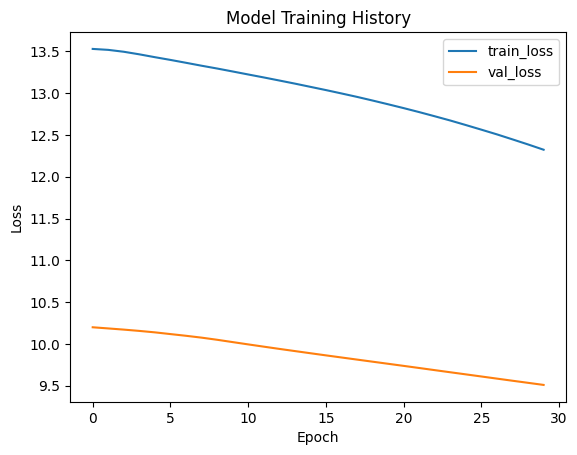

c:\Users\Rizki\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
c:\Users\Rizki\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Model dan mappings berhasil disimpan

Contoh rekomendasi untuk User 1 dengan budget 50.000:
4/4 [==============================] - 0s 3ms/step
              Place_Name       Category  Price  Predicted_Rating
5   De Mata Museum Jogja         Budaya  50000          0.180199
59     Desa Wisata Tembi  Taman Hiburan  50000          0.145220
82       Candi Borobudur         Budaya  50000          0.142660
38       Candi Prambanan         Budaya  50000          0.138575
34            Goa Pindul     Cagar Alam  40000          0.131811


In [1]:
# %%
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# %%
# Load dataset
df = pd.read_csv('../Datasets/DatasetTouris.csv')

# Filter data Jogja
df_jogja = df[df['City'].str.contains('yogyakarta|diy', case=False, na=False)].copy()

# Preprocessing
df_jogja = df_jogja.dropna(subset=['Place_Ratings', 'Price'])
df_jogja = df_jogja.drop_duplicates(subset='Place_Id')

# Feature engineering
df_jogja['Budget_Category'] = pd.cut(
    df_jogja['Price'],
    bins=[0, 20000, 50000, 100000, np.inf],
    labels=['Sangat Murah', 'Murah', 'Sedang', 'Mahal']
)

# Normalisasi fitur numerik
scaler = MinMaxScaler()
df_jogja['Rating_Norm'] = scaler.fit_transform(df_jogja[['Rating']])
df_jogja['Price_Norm'] = scaler.fit_transform(df_jogja[['Price']])

# %%
# Collaborative Filtering Model (Neural Network)
def build_collab_filter_model(n_users, n_places, embedding_size=50):
    # Input layers
    user_input = Input(shape=(1,))
    place_input = Input(shape=(1,))
    
    # Embedding layers
    user_embedding = Embedding(n_users, embedding_size)(user_input)
    place_embedding = Embedding(n_places, embedding_size)(place_input)
    
    # Dot product
    dot_product = Dot(axes=2)([user_embedding, place_embedding])
    dot_product = Flatten()(dot_product)
    
    # Budget impact layer
    budget_input = Input(shape=(1,))
    budget_dense = Dense(10, activation='relu')(budget_input)
    
    # Concatenate with dot product
    merged = Concatenate()([dot_product, budget_dense])
    output = Dense(1, activation='relu')(merged)
    
    model = Model(inputs=[user_input, place_input, budget_input], outputs=output)
    model.compile(loss='mse', optimizer=Adam(0.001))
    
    return model

# %%
# Prepare data for collaborative filtering
user_ids = df_jogja['User_Id'].unique()
place_ids = df_jogja['Place_Id'].unique()

# Create mappings
user_to_index = {user_id: idx for idx, user_id in enumerate(user_ids)}
place_to_index = {place_id: idx for idx, place_id in enumerate(place_ids)}

# Prepare dataset
X = df_jogja[['User_Id', 'Place_Id', 'Price_Norm']]
y = df_jogja['Place_Ratings']

# Convert to indices
X['user_idx'] = X['User_Id'].map(user_to_index)
X['place_idx'] = X['Place_Id'].map(place_to_index)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X[['user_idx', 'place_idx', 'Price_Norm']], 
    y, 
    test_size=0.2,
    random_state=42
)

# %%
# Build and train model
model = build_collab_filter_model(
    n_users=len(user_ids),
    n_places=len(place_ids),
    embedding_size=50
)

history = model.fit(
    [X_train['user_idx'], X_train['place_idx'], X_train['Price_Norm']],
    y_train,
    batch_size=64,
    epochs=30,
    validation_split=0.1,
    verbose=1
)

# Plot training history
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Training History')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# %%
# Hybrid Recommendation Function
def hybrid_recommendation(user_id, budget, n_recommendations=5):
    try:
        # Konversi budget ke skala normalisasi
        budget_scaled = scaler.transform([[budget]])[0][0]
        
        # Prediksi rating untuk semua tempat di Jogja
        user_idx = user_to_index.get(user_id, -1)
        
        if user_idx == -1:
            # Fallback untuk user baru
            return content_based_fallback(budget)
        
        # Buat prediksi untuk semua tempat
        all_places = df_jogja['Place_Id'].unique()
        place_indices = [place_to_index[p] for p in all_places]
        
        user_array = np.array([user_idx] * len(all_places))
        budget_array = np.array([budget_scaled] * len(all_places))
        
        predictions = model.predict([
            user_array,
            np.array(place_indices),
            budget_array
        ]).flatten()
        
        # Buat dataframe hasil
        recommendations = pd.DataFrame({
            'Place_Id': all_places,
            'Predicted_Rating': predictions
        })
        
        # Gabungkan dengan informasi tempat
        recommendations = recommendations.merge(
            df_jogja[['Place_Id', 'Place_Name', 'Category', 'Price', 'Rating']],
            on='Place_Id'
        )
        
        # Filter berdasarkan budget
        budget_min = budget * 0.7
        budget_max = budget * 1.3
        filtered = recommendations[
            (recommendations['Price'] >= budget_min) & 
            (recommendations['Price'] <= budget_max)
        ]
        
        # Jika ada hasil dalam rentang budget
        if not filtered.empty:
            return filtered.sort_values('Predicted_Rating', ascending=False).head(n_recommendations)
        
        # Fallback jika tidak ada dalam rentang budget
        return content_based_fallback(budget, n_recommendations)
    
    except Exception as e:
        print(f"Error: {str(e)}")
        return content_based_fallback(budget, n_recommendations)

# %%
# Content-based Fallback
def content_based_fallback(budget, n_recommendations=5):
    try:
        # Filter tempat dalam rentang budget
        budget_min = budget * 0.7
        budget_max = budget * 1.3
        filtered = df_jogja[
            (df_jogja['Price'] >= budget_min) & 
            (df_jogja['Price'] <= budget_max)
        ]
        
        # Jika ada hasil dalam rentang
        if not filtered.empty:
            return filtered.sort_values('Rating', ascending=False).head(n_recommendations)
        
        # Jika tidak ada, cari yang paling mendekati budget
        df_jogja['Budget_Diff'] = abs(df_jogja['Price'] - budget)
        return df_jogja.sort_values(['Budget_Diff', 'Rating'], ascending=[True, False]).head(n_recommendations)
    
    except:
        # Fallback akhir: rekomendasi terpopuler
        return df_jogja.sort_values('Rating', ascending=False).head(n_recommendations)

# %%
# Simpan model dan mapping
import joblib

model.save('../Model/hybrid_recommender.h5')
joblib.dump({
    'user_to_index': user_to_index,
    'place_to_index': place_to_index,
    'scaler': scaler
}, '../Model/mappings.joblib')

print("Model dan mappings berhasil disimpan")

# %%
# Contoh penggunaan
print("\nContoh rekomendasi untuk User 1 dengan budget 50.000:")
rec = hybrid_recommendation(user_id=1, budget=50000)
print(rec[['Place_Name', 'Category', 'Price', 'Predicted_Rating']])

✅ Dataset loaded successfully
Total records: 10000
Columns available: ['User_Id', 'Place_Id', 'Place_Ratings', 'Place_Name', 'Description', 'Category', 'City', 'Price', 'Rating', 'Coordinate', 'Lat', 'Long', 'Location', 'Age']

🔍 Data Jogja ditemukan: 2871 destinasi
✅ Preprocessing selesai
✅ TF-IDF matrix shape: (126, 1000)
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 user_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 place_input (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 embedding_2 (Embedding)     (None, 1, 32)                1216 

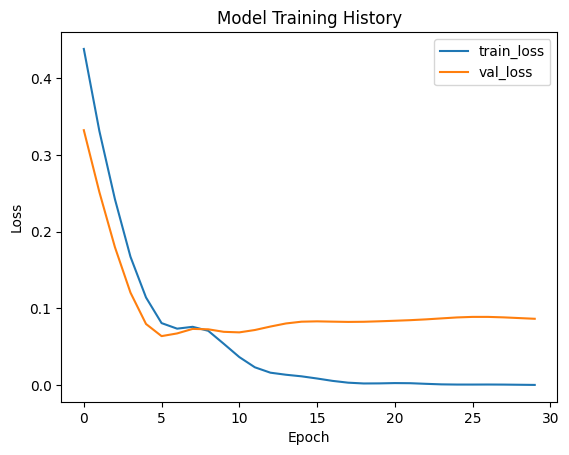

c:\Users\Rizki\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
c:\Users\Rizki\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


💾 Model dan assets berhasil disimpan

🎯 Rekomendasi berbasis tempat (ID: 143)
    Place_Id            Place_Name       Category  Rating    Price  \
38       121       Candi Prambanan         Budaya     4.7  50000.0   
82       170       Candi Borobudur         Budaya     4.7  50000.0   
19       193            Candi Sewu         Budaya     4.6  50000.0   
59       205     Desa Wisata Tembi  Taman Hiburan     4.5  50000.0   
5         89  De Mata Museum Jogja         Budaya     4.4  50000.0   

          Budget_Status  
38  Alternatif Terdekat  
82  Alternatif Terdekat  
19  Alternatif Terdekat  
59  Alternatif Terdekat  
5   Alternatif Terdekat  

🧑 Rekomendasi hybrid untuk user 4 dengan budget 100000
4/4 [==============================] - 0s 4ms/step
     Place_Id  Predicted_Rating            Place_Name Category     Price  \
122       175       4854.732422  Museum Ullen Sentalu   Budaya  100000.0   
0         179       4854.661621       Candi Ratu Boko   Budaya   75000.0   

     Rati

c:\Users\Rizki\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [2]:
# %% [1. Impor Library]
import pandas as pd
import numpy as np
import ast
import joblib
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import re

# %% [2. Load dan Preprocess Data]
# Load dataset
try:
    df = pd.read_csv('../Datasets/DatasetTouris.csv')
    print("✅ Dataset loaded successfully")
    print(f"Total records: {len(df)}")
    print("Columns available:", df.columns.tolist())
except FileNotFoundError:
    print("❌ Error: File not found.")
    print("Current working directory:", os.getcwd())
    exit()

# Filter data Jogja
if 'City' in df.columns:
    df_jogja = df[df['City'].str.contains('yogyakarta|diy', case=False, na=False)].copy()
    print(f"\n🔍 Data Jogja ditemukan: {len(df_jogja)} destinasi")
    
    # Preprocessing
    df_jogja = df_jogja.drop_duplicates(subset='Place_Id').reset_index(drop=True)
    df_jogja['Price'] = df_jogja['Price'].fillna(0).astype(float)
    df_jogja['Rating'] = df_jogja['Rating'].fillna(df_jogja['Rating'].median()).astype(float)
    df_jogja['Place_Ratings'] = df_jogja['Place_Ratings'].fillna(df_jogja['Rating']).astype(float)
    
    # Bersihkan deskripsi
    def clean_description(text):
        if pd.isna(text):
            return ""
        text = re.sub(r'\[.*?\]', '', text)  # Hapus teks dalam kurung siku
        text = re.sub(r'\(.*?\)', '', text)  # Hapus teks dalam kurung biasa
        text = re.sub(r'\b\d+\b', '', text)  # Hapus angka tunggal
        text = re.sub(r'\s+', ' ', text)  # Hapus spasi berlebih
        return text.strip()
    
    df_jogja['Description'] = df_jogja['Description'].apply(clean_description)
    
    # Buat fitur teks gabungan
    df_jogja['Composite_Features'] = (
        df_jogja['Place_Name'] + ' ' +
        df_jogja['Category'] + ' ' +
        df_jogja['Description']
    )
    
    print("✅ Preprocessing selesai")
else:
    print("❌ Kolom 'City' tidak ditemukan.")
    exit()

# %% [3. TF-IDF Vectorizer]
stopwords_indonesia = [
    'yang', 'di', 'ke', 'dari', 'dan', 'untuk', 'pada', 'dengan', 'ini', 'itu',
    'atau', 'juga', 'dalam', 'tidak', 'akan', 'ada', 'oleh', 'karena', 'bisa', 'serta', 'juga'
]

tfidf = TfidfVectorizer(
    stop_words=stopwords_indonesia,
    ngram_range=(1, 2),
    max_features=1000
)
tfidf_matrix = tfidf.fit_transform(df_jogja['Composite_Features'])
print(f"✅ TF-IDF matrix shape: {tfidf_matrix.shape}")

# %% [4. Content-Based Fallback System]
def content_based_recommendation(place_id=None, budget=None, n=5):
    """Sistem rekomendasi berbasis konten dengan filter budget"""
    try:
        # Jika ada place_id, cari rekomendasi similaritas
        if place_id:
            if place_id not in df_jogja['Place_Id'].values:
                print("⚠️ Place ID tidak ditemukan, menggunakan top rating")
                return fallback_top_rating(n)
            
            idx = df_jogja.index[df_jogja['Place_Id'] == place_id].tolist()[0]
            sim_scores = list(enumerate(cosine_similarity(tfidf_matrix)[idx]))
            sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:n+1]
            recommendations = df_jogja.iloc[[i[0] for i in sim_scores]]
        
        # Jika tidak ada place_id, gunakan top rating
        else:
            recommendations = df_jogja.copy()
        
        # Filter berdasarkan budget jika ada
        if budget:
            budget = float(budget)
            budget_min = budget * 0.7
            budget_max = budget * 1.3
            recommendations = recommendations[
                (recommendations['Price'] >= budget_min) & 
                (recommendations['Price'] <= budget_max)
            ]
            
            # Jika tidak ada hasil, cari yang mendekati
            if recommendations.empty:
                df_jogja['Budget_Diff'] = abs(df_jogja['Price'] - budget)
                recommendations = df_jogja.sort_values(['Budget_Diff', 'Rating'], 
                                                       ascending=[True, False]).head(n)
                recommendations['Budget_Status'] = 'Alternatif Terdekat'
                return recommendations[['Place_Id', 'Place_Name', 'Category', 'Rating', 'Price', 'Budget_Status']]
        
        return recommendations[['Place_Id', 'Place_Name', 'Category', 'Rating', 'Price']].head(n)
    
    except Exception as e:
        print(f"Error in content-based: {str(e)}")
        return fallback_top_rating(n)

def fallback_top_rating(n=5):
    """Rekomendasi rating tertinggi"""
    return df_jogja.sort_values(by='Rating', ascending=False).head(n)[
        ['Place_Id', 'Place_Name', 'Category', 'Rating', 'Price']
    ]

def fallback_best_value(n=5):
    """Rekomendasi value for money terbaik"""
    df_val = df_jogja.copy()
    df_val['Value_Score'] = df_val.apply(
        lambda x: x['Rating'] / np.log1p(x['Price'] + 1) if x['Price'] > 0 else x['Rating'],
        axis=1
    )
    return df_val.sort_values(by='Value_Score', ascending=False).head(n)[
        ['Place_Id', 'Place_Name', 'Category', 'Rating', 'Price', 'Value_Score']
    ]

# %% [5. Hybrid Recommendation Model]
# Persiapan data untuk model hybrid
user_ids = df_jogja['User_Id'].unique()
place_ids = df_jogja['Place_Id'].unique()

# Mapping
user_to_index = {user_id: idx for idx, user_id in enumerate(user_ids)}
place_to_index = {place_id: idx for idx, place_id in enumerate(place_ids)}

# Normalisasi
scaler = MinMaxScaler()
df_jogja['Price_Norm'] = scaler.fit_transform(df_jogja[['Price']])
df_jogja['Place_Ratings_Norm'] = scaler.fit_transform(df_jogja[['Place_Ratings']])

# Siapkan dataset
X = df_jogja.copy()
X['user_idx'] = X['User_Id'].map(user_to_index)
X['place_idx'] = X['Place_Id'].map(place_to_index)

# Train-test split
train, test = train_test_split(X, test_size=0.2, random_state=42)

# %% [6. Bangun Model Hybrid Neural Network]
def build_hybrid_model(n_users, n_places, embedding_size=32):
    # Input layers
    user_input = Input(shape=(1,), name='user_input')
    place_input = Input(shape=(1,), name='place_input')
    budget_input = Input(shape=(1,), name='budget_input')
    text_input = Input(shape=(tfidf_matrix.shape[1],), name='text_input')
    
    # User and place embeddings
    user_embed = Embedding(n_users, embedding_size)(user_input)
    user_vec = Flatten()(user_embed)
    
    place_embed = Embedding(n_places, embedding_size)(place_input)
    place_vec = Flatten()(place_embed)
    
    # Concatenate all features
    concat = Concatenate()([user_vec, place_vec, budget_input, text_input])
    
    # Deep neural network
    dense = Dense(128, activation='relu')(concat)
    dense = Dense(64, activation='relu')(dense)
    output = Dense(1, activation='linear')(dense)
    
    model = Model(
        inputs=[user_input, place_input, budget_input, text_input],
        outputs=output
    )
    model.compile(loss='mse', optimizer=Adam(0.001), metrics=['mae'])
    
    return model

# Inisialisasi model
model = build_hybrid_model(
    n_users=len(user_ids),
    n_places=len(place_ids),
    embedding_size=32
)
model.summary()

# %% [7. Train Model]
# Ekstrak fitur teks untuk training
train_text = tfidf.transform(train['Composite_Features']).toarray()
test_text = tfidf.transform(test['Composite_Features']).toarray()

# Training
history = model.fit(
    [
        train['user_idx'],
        train['place_idx'],
        train['Price_Norm'],
        train_text
    ],
    train['Place_Ratings_Norm'],
    epochs=30,
    batch_size=64,
    validation_data=(
        [
            test['user_idx'],
            test['place_idx'],
            test['Price_Norm'],
            test_text
        ],
        test['Place_Ratings_Norm']
    ),
    verbose=1
)

# Plot training history
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Training History')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# %% [8. Fungsi Rekomendasi Hybrid]
def hybrid_recommendation(user_id, budget, n=5):
    """
    Rekomendasi hybrid dengan personalisasi user dan filter budget
    """
    try:
        # Konversi budget ke bentuk normalisasi
        budget_scaled = scaler.transform([[budget]])[0][0]
        
        # Cek apakah user dikenal
        user_idx = user_to_index.get(user_id, -1)
        
        # Jika user tidak dikenal, gunakan content-based
        if user_idx == -1:
            print("⚠️ User tidak dikenali, menggunakan content-based")
            return content_based_recommendation(budget=budget, n=n)
        
        # Siapkan semua tempat di Jogja
        all_places = df_jogja['Place_Id'].unique()
        place_indices = [place_to_index[p] for p in all_places]
        
        # Buat array input
        user_array = np.array([user_idx] * len(all_places))
        budget_array = np.array([budget_scaled] * len(all_places))
        
        # Ekstrak fitur teks untuk semua tempat
        all_text = tfidf.transform(
            df_jogja[df_jogja['Place_Id'].isin(all_places)]['Composite_Features']
        ).toarray()
        
        # Prediksi rating
        predictions = model.predict([
            user_array,
            np.array(place_indices),
            budget_array,
            all_text
        ]).flatten()
        
        # Buat dataframe hasil
        recommendations = pd.DataFrame({
            'Place_Id': all_places,
            'Predicted_Rating': predictions
        })
        
        # Gabungkan dengan informasi tempat
        recommendations = recommendations.merge(
            df_jogja[['Place_Id', 'Place_Name', 'Category', 'Price', 'Rating']],
            on='Place_Id'
        ).drop_duplicates()
        
        # Filter berdasarkan budget
        budget_min = budget * 0.7
        budget_max = budget * 1.3
        filtered = recommendations[
            (recommendations['Price'] >= budget_min) & 
            (recommendations['Price'] <= budget_max)
        ]
        
        # Jika ada hasil dalam rentang budget
        if not filtered.empty:
            return filtered.sort_values('Predicted_Rating', ascending=False).head(n)
        
        # Fallback jika tidak ada dalam rentang budget
        print("⚠️ Tidak ada dalam rentang budget, gunakan best value")
        return fallback_best_value(n)
    
    except Exception as e:
        print(f"🚨 Error in hybrid recommendation: {str(e)}")
        return content_based_recommendation(budget=budget, n=n)

# %% [9. Simpan Model]
# Buat direktori jika belum ada
os.makedirs('../Model', exist_ok=True)

# Simpan model neural network
model.save('../Model/hybrid_recommender.h5')

# Simpan TF-IDF dan mapping
joblib.dump(
    {
        'tfidf': tfidf,
        'user_to_index': user_to_index,
        'place_to_index': place_to_index,
        'scaler': scaler
    },
    '../Model/recommender_assets.joblib'
)

print("💾 Model dan assets berhasil disimpan")

# %% [10. Contoh Penggunaan]
if not df_jogja.empty:
    # Contoh content-based
    sample_place = df_jogja.sample(1)['Place_Id'].values[0]
    print(f"\n🎯 Rekomendasi berbasis tempat (ID: {sample_place})")
    print(content_based_recommendation(place_id=sample_place, budget=50000))
    
    # Contoh hybrid
    sample_user = df_jogja.sample(1)['User_Id'].values[0]
    print(f"\n🧑 Rekomendasi hybrid untuk user {sample_user} dengan budget 100000")
    print(hybrid_recommendation(user_id=sample_user, budget=100000))
    
    # Contoh fallback
    print("\n🏆 Top Rating di Jogja")
    print(fallback_top_rating())
    
    print("\n💸 Best Value for Money")
    print(fallback_best_value())

# %% [11. Fungsi Utama untuk Aplikasi]
def get_recommendations(user_id=None, place_id=None, budget=None, n=5):
    """
    Fungsi utama untuk mendapatkan rekomendasi:
    - Jika ada user_id: gunakan hybrid recommendation
    - Jika ada place_id: gunakan content-based
    - Jika hanya budget: gunakan content-based dengan budget
    - Jika tidak ada: return top rating
    """
    try:
        # Prioritas 1: Hybrid recommendation (user_id + budget)
        if user_id and budget:
            return hybrid_recommendation(user_id, budget, n)
        
        # Prioritas 2: Content-based (place_id + budget)
        elif place_id and budget:
            return content_based_recommendation(place_id, budget, n)
        
        # Prioritas 3: Content-based dengan budget
        elif budget:
            return content_based_recommendation(budget=budget, n=n)
        
        # Prioritas 4: Content-based tanpa budget
        elif place_id:
            return content_based_recommendation(place_id=place_id, n=n)
        
        # Fallback: Top rating
        else:
            return fallback_top_rating(n)
    
    except Exception as e:
        print(f"🚨 Critical error: {str(e)}")
        return fallback_top_rating(n)

# Contoh penggunaan fungsi utama
print("\n🌟 Contoh penggunaan fungsi utama:")
print("1. Hybrid:", get_recommendations(user_id=1, budget=50000))
print("\n2. Content-based:", get_recommendations(place_id=179, budget=30000))
print("\n3. Budget only:", get_recommendations(budget=75000))
print("\n4. Place only:", get_recommendations(place_id=344))
print("\n5. No params:", get_recommendations())